# Procesamiento de fuentes de datos

Este notebook explica los procedimientos para obtener los datos que se usan en la librería a partir de las fuentes originales.

In [8]:
import pandas as pd
import geopandas as gpd
from criminologia_cdmx.covariables import *
from criminologia_cdmx.etl import DATA_PATH, DOWNLOADS_PATH
import numpy as np
import requests
import xml.etree.ElementTree as ET
import os
from zipfile import ZipFile
import shutil
from pathlib import Path

In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Relación manzanas-colonias-cuadrantes

Varias funciones al interior de la librería utilizan esta relación para hacer asignaciones. Esta sección documenta el proceso de asignación.

:::{.callout-note}

Este notebook utiliza fuentes de datos que no son usadas directamente en la librería por lo que no tienen su función para descargarlas. La primera que vamos a usar son las [manzanas](manzanas https://www.dropbox.com/s/2ik1juh8h5bxetb/manzanas_2020_cdmx.zip?dl=1) del censo 2020

:::



In [10]:
# Leemos las geometrías de manzanas, y procesamos un poco
manzanas = gpd.read_file(DOWNLOADS_PATH/"manzanas_2020_cdmx.zip")
# Agregamos CVEGEO a las manzanas y quitamos las columnas que la componen
manzanas['CVEGEO']  = manzanas['CVE_ENT'] + manzanas['CVE_MUN'] + manzanas['CVE_LOC'] + manzanas['CVE_AGEB'] + manzanas['CVE_MZA']
manzanas = manzanas.drop(columns=['CVE_ENT', 'CVE_MUN',	'CVE_LOC', 'CVE_AGEB', 'CVE_MZA'])
manzanas.head()

,CVEGEO,AMBITO,TIPOMZA,geometry
0,0901000010898031,Urbana,Típica,"POLYGON ((2790204.135 820779.247, 2790125.593 ..."
1,0901000012269024,Urbana,Típica,"POLYGON ((2791387.916 821465.156, 2791376.215 ..."
2,0901000011472068,Urbana,Típica,"POLYGON ((2788494.355 822775.106, 2788478.422 ..."
3,0901000011824024,Urbana,Típica,"POLYGON ((2790870.494 819456.298, 2790862.256 ..."
4,0901000012377004,Urbana,Típica,"POLYGON ((2792111.138 821977.886, 2792115.437 ..."


Leemos colonias y cuadrantes. Estas capas forman parte de la librería y están disponobles después de instalarla

:::{.callout-note}

La capa de colonias es una versión derivada de la disponible en Datos Abiertos CDMX a la que le arreglamos la topología.

Los cuadrantes salen también de Datos Abiertos CDMX

:::

In [11]:
colonias = gpd.read_file(DATA_PATH/"criminologia_capas.gpkg", layer='colonias')
cuadrantes = gpd.read_file(DATA_PATH/"criminologia_capas.gpkg", layer='cuadrantes')

Para crear la asociación de manzanas a las unidades de colonias y cuadrantes, vamos a calcular un _punto representativo_ para cada manzana (es decir, un punto al interior de cada polígono) y lo vamos a usar para una unión espacial con las geometrías de colonias y cuadrantes.

In [12]:
# Extraemos puntos al interior de las manzanas
puntos_manzanas = manzanas.loc[:, ['CVEGEO', 'geometry']]
puntos_manzanas['geometry'] = puntos_manzanas['geometry'].representative_point()
# Unimos los puntos con las geometrías de cuadrantes y colonias
puntos_manzanas = (gpd
                   .sjoin(puntos_manzanas, colonias.to_crs(puntos_manzanas.crs)[['geometry', 'colonia_cve', 'colonia_nombre']], how='left')
                   .drop(columns='index_right'))
puntos_manzanas['colonia_cve'] = puntos_manzanas['colonia_cve'].astype('Int64')
puntos_manzanas = (gpd
                   .sjoin(puntos_manzanas, cuadrantes.to_crs(puntos_manzanas.crs)[['geometry', 'cuadrante_id']], how='left')
                   .drop(columns='index_right'))
# Unimos de regreso a las manzanas
manzanas = manzanas.merge(puntos_manzanas[['CVEGEO', 'colonia_cve', 'cuadrante_id', 'colonia_nombre']], on='CVEGEO', how='left')
manzanas[['CVEGEO', 'colonia_cve', 'colonia_nombre', 'cuadrante_id']]

,CVEGEO,colonia_cve,colonia_nombre,cuadrante_id
0,0901000010898031,1656,HERON PROAL,017
1,0901000012269024,1716,LOMAS DE TARANGO,014
2,0901000011472068,1652,GRAL A ROSALES,011
3,0901000011824024,1772,SAN CLEMENTE,0110
4,0901000012377004,1657,HOGAR Y REDENCION,018
...,...,...,...,...
66975,0900700015376020,1031,ZONA MILITAR FAVE SEDENA (U HAB),019
66976,0900700015376021,1031,ZONA MILITAR FAVE SEDENA (U HAB),019
66977,0900700013045056,807,DESARROLLO URBANO QUETZALCOATL I,0113
66978,0900700013045032,807,DESARROLLO URBANO QUETZALCOATL I,0113


In [13]:
manzanas.to_file(DOWNLOADS_PATH/'manzanas_identificadores.gpkg', layer='manzanas', driver="GPKG")

Esta capa es la que podemos descargar con la función `descarga_manzanas` del  módulo `etl`.

## Procesamiento de datos del Censo 2020

Aquí vamos a partir de la base del Censo por AGEB urbana descargable de INEGI, quedarnos con la escala de manzanas y homogeneizar algunas cuestiones.

:::{.callout-note}

Para no ir a buscarlos al sitio de INEGI, podemos descargar los datos de [aquí](https://www.dropbox.com/s/ddatnats78e03cz/conjunto_de_datos_ageb_urbana_09_cpv2020.zip?dl=1)

:::

In [ ]:
censo = pd.read_csv(DOWNLOADS_PATH/"conjunto_de_datos_ageb_urbana_09_cpv2020.zip", 
                    dtype={"ENTIDAD":str, "MUN": str, "LOC":str, "AGEB":str, "MZA": str})
# Nos quedamos sólo con las filas que tienen datos de manzanas (no localidad, agebs, etc)
censo = censo.loc[censo['MZA'] != '000']
# Construimos la cvegeo de las manzanas
censo['CVEGEO'] = censo['ENTIDAD'] + censo['MUN'] + censo['LOC'] + censo['AGEB'] + censo['MZA']
censo.head()

,ENTIDAD,NOM_ENT,MUN,NOM_MUN,LOC,NOM_LOC,AGEB,MZA,POBTOT,POBFEM,...,VPH_CEL,VPH_INTER,VPH_STVP,VPH_SPMVPI,VPH_CVJ,VPH_SINRTV,VPH_SINLTC,VPH_SINCINT,VPH_SINTIC,CVEGEO
4,09,Ciudad de México,002,Azcapotzalco,0001,Azcapotzalco,0010,001,159,86,...,42,39,18,13,6,*,0,9,0,0900200010010001
5,09,Ciudad de México,002,Azcapotzalco,0001,Azcapotzalco,0010,002,145,80,...,38,32,14,12,5,0,0,9,0,0900200010010002
6,09,Ciudad de México,002,Azcapotzalco,0001,Azcapotzalco,0010,003,124,64,...,28,25,11,15,7,0,*,6,0,0900200010010003
7,09,Ciudad de México,002,Azcapotzalco,0001,Azcapotzalco,0010,004,158,83,...,38,34,14,4,7,0,0,7,0,0900200010010004
8,09,Ciudad de México,002,Azcapotzalco,0001,Azcapotzalco,0010,005,154,86,...,42,38,12,5,6,0,0,7,0,0900200010010005


### Tipos de datos

* Codificar bien los Nan
* Utilizar tipos de datos adecuados

In [ ]:
diccionario = get_diccionario_censo()
# Codificamos los Nan
censo = censo.replace('999999999', np.nan) 
censo = censo.replace('99999999', np.nan)
censo = censo.replace('*', np.nan)
censo = censo.replace('N/D', np.nan)
# Cambiamos los tipos de datos
campos_datos = diccionario['Nombre del Campo'].unique()
censo[campos_datos] = censo[campos_datos].astype('float')
censo.dtypes

ENTIDAD         object
NOM_ENT         object
MUN             object
NOM_MUN         object
LOC             object
                ...   
VPH_SINRTV     float64
VPH_SINLTC     float64
VPH_SINCINT    float64
VPH_SINTIC     float64
CVEGEO          object
Length: 231, dtype: object

### Asociar cuadrantes y colonias

In [ ]:
censo = censo.merge(manzanas[['CVEGEO', 'AMBITO', 'TIPOMZA', 'colonia_cve', 'cuadrante_id']], on='CVEGEO')
censo[['CVEGEO', 'colonia_cve', 'cuadrante_id']].head()

,CVEGEO,colonia_cve,cuadrante_id
0,0900200010010001,20,021
1,0900200010010002,20,021
2,0900200010010003,20,021
3,0900200010010004,20,021
4,0900200010010005,20,021


### Guardarlos datos

Guardamos el archivo como _csv_ en la carpeta de datos de la librería. Este archivo estará disponible al instalar

In [ ]:
censo.drop(columns=['NOM_ENT', 'NOM_MUN', 'NOM_LOC', 
                       'AGEB', 'MZA']).to_csv(DATA_PATH/'censo_manzanas.zip', index=False)

## Uso de suelo

Dentro de las covariables también podemos usar datos de uso de suelo y estructura urbana, por lo pronto tenemos:

**Usos de Suelo**
* comercio
* industria
* servicios

**Estructura urbana**
* intensidad: la suma de los usos de suelo
* entropia: la mezcla

Todas estas variables salen del DENUE. Segúramente no son las ideales en este momento para el análisis delictivo, más adelante iremos incorporando otras.

Todos los conteos están calculados por manzana, pero para calcular mezcals de uso de suelo no es la mejor unidad porque es posible que se capture demasiado ruido, más adelante habría que hacer algún tipo de suavizado espacial.

:::{.callout-warning}

Estas variables son provisionales, eventualmente los datos de uso de suelo vendrán de una librería que está en desarrollo

:::

In [ ]:
# Bajamos y leemos los datos
entropia_url = "https://www.dropbox.com/s/mke0xlxj832yrbz/MANZANAS_2020_ENTROPIA_MEXICO_PAIS.zip?dl=1"
r = requests.get(entropia_url, allow_redirects=True)
open(DOWNLOADS_PATH/'entropia.zip', 'wb').write(r.content)
entropia = gpd.read_file(DOWNLOADS_PATH/"entropia.zip")
entropia.head()

,OBJECTID,CVEGEO,POB1,VIV0,Sum_I,Sum_C,Sum_S,ENTROPIA,Shape_Leng,Shape_Area,geometry
0,1,0100600010051001,131.0,29.0,0,4,8,0.57047,397.188142,9542.547046,"POLYGON ((2470881.125 1125252.760, 2470876.423..."
1,2,0100600010051002,136.0,33.0,2,1,2,0.38100,405.604062,6809.005897,"POLYGON ((2470771.604 1125251.148, 2470820.703..."
2,3,0100600010051003,87.0,24.0,0,4,6,0.57978,334.281393,4591.822145,"POLYGON ((2470822.740 1125267.550, 2470817.233..."
3,4,0100600010051004,54.0,17.0,3,5,6,0.84224,443.655394,9534.012627,"POLYGON ((2470856.211 1125430.736, 2470860.908..."
4,5,0100600010051005,134.0,33.0,0,6,3,0.47319,408.723634,10046.410286,"POLYGON ((2470943.992 1125503.345, 2470945.272..."


Extraemos sólo CDMX

In [ ]:
entropia = entropia.loc[entropia['CVEGEO'].str.slice(0,2) == '09']
entropia.head()

,OBJECTID,CVEGEO,POB1,VIV0,Sum_I,Sum_C,Sum_S,ENTROPIA,Shape_Leng,Shape_Area,geometry
303170,303171,0901000010898031,93.0,25.0,1,4,5,0.62598,262.568321,3257.627213,"POLYGON ((2790204.135 820779.247, 2790125.593 ..."
303171,303172,0901000012269024,6.0,2.0,0,0,0,0.00000,99.416498,620.047356,"POLYGON ((2791387.916 821465.156, 2791376.215 ..."
303172,303173,0901000011472068,124.0,36.0,1,1,0,0.17505,273.339185,2902.584864,"POLYGON ((2788494.355 822775.106, 2788478.422 ..."
303173,303174,0901000011824024,340.0,100.0,0,3,2,0.16122,549.208571,7705.820177,"POLYGON ((2790870.494 819456.298, 2790862.256 ..."
303174,303175,0901000012377004,82.0,25.0,0,0,0,0.00000,311.543573,2712.170580,"POLYGON ((2792111.138 821977.886, 2792115.437 ..."


Unimos a los identificadores de cuadrante y colonia. De los datos de arriba sólo queremos realmente los conteos `Sum_I`, `Sum_C` y `Sum_S`, las demás variables hay que recalcularlas.

In [ ]:
entropia = entropia[['CVEGEO', 'Sum_I', 'Sum_C', 'Sum_S']]
entropia = (censo[['CVEGEO', 'colonia_cve', 'cuadrante_id']]
            .merge(entropia, on='CVEGEO')
            .rename({'Sum_I':'Industria', 'Sum_C': 'Comercio', 'Sum_S':'Servicios'}, axis=1))
entropia

,CVEGEO,colonia_cve,cuadrante_id,Industria,Comercio,Servicios
0,0900200010010001,20,021,1,9,1
1,0900200010010002,20,021,1,1,8
2,0900200010010003,20,021,0,9,4
3,0900200010010004,20,021,1,5,3
4,0900200010010005,20,021,1,6,8
...,...,...,...,...,...,...
66567,0901700011524021,1432,032,0,0,2
66568,0901700011524022,1432,032,0,3,0
66569,0901700011524023,1432,032,2,10,5
66570,0901700011524024,1432,032,2,6,11


:::{.callout-warning}

Hay manzanas que no van a tener datos, eso se arreglará en la librería que se encuentra en desarrollo.

:::

Estos datos también se encuentran (por lo pronto), disponibles al instalar la librería.

In [ ]:
entropia.to_csv(DATA_PATH/"usos_suelo.csv", index=False)

## Datos 911

Los datos de llamadas del 911 se encuentran disponibles en la página de datos abiertos de la CDMX. Hay un archivo por cada semestre desde 2019.

Por lo pronto, en lugar de proveer funciones como para carpetas y víctimas vamos a procesar un único archivo.

A continuación vamos a abrir un archivo csv que integra todos los concentrados semestrales sin ningún otro procesamiento. El archivo se puede descargar de [aquí](https://www.dropbox.com/s/l83t5ak108hz2ax/911_19-21_unidas.csv.zip?dl=1)

In [ ]:
datos_911 = pd.read_csv(DOWNLOADS_PATH/"911_19-21_unidas.csv.zip", dtype=object)
datos_911.head()

,folio,incidente_c4,fecha_creacion,hora_creacion,mes_creacion,año_creacion,fecha_cierre,mes_cierre,año_cierre,hora_cierre,...,clas_con_f_alarma,delegacion_cierre,manzana,longitud_centroide,latitud_centroide,geometry,aÃ±o_creacion,aÃ±o_cierre,aħo_creacion,aħo_cierre
0,C5/200702/07369,Lesionado-Caída,2020-07-02,21:25:59,Julio,2020.0,2020-07-02,Julio,2020.0,21:30:35,...,URGENCIAS MEDICAS,GUSTAVO A. MADERO,0900500012907021,-99.09506,19.48655,"MULTIPOLYGON (((-99.09512274 19.4871496299991,...",NaN,NaN,NaN,NaN
1,C5/200702/07404,Lesionado-Caída,2020-07-02,21:30:30,Julio,2020.0,2020-07-02,Julio,2020.0,22:29:43,...,URGENCIAS MEDICAS,BENITO JUAREZ,0901400010257024,-99.16083,19.393539999999998,"MULTIPOLYGON (((-99.16050212 19.3939641699992,...",NaN,NaN,NaN,NaN
2,C5/200702/07419,Denuncia-Hechos,2020-07-02,21:32:27,Julio,2020.0,2020-07-02,Julio,2020.0,21:42:31,...,SERVICIO,CUAUHTEMOC,0901500011144017,-99.14010999999999,19.4177,"MULTIPOLYGON (((-99.14056138 19.4175488299992,...",NaN,NaN,NaN,NaN
3,C5/200702/07300,Agresión-Casa Habitación,2020-07-02,21:13:59,Julio,2020.0,2020-07-02,Julio,2020.0,22:05:50,...,DELITO,MILPA ALTA,0900900360223055,-99.00204000000001,19.17844,NaN,NaN,NaN,NaN,NaN
4,C5/200702/07342,Denuncia-Menor en riesgo,2020-07-02,21:21:51,Julio,2020.0,2020-07-02,Julio,2020.0,21:49:46,...,SERVICIO,GUSTAVO A. MADERO,0900500011557005,-99.14424,19.47489,"MULTIPOLYGON (((-99.14416797 19.4742978599991,...",NaN,NaN,NaN,NaN


Lo primero que vamos a hacer es elimirar columnas repetidas y la columna geometry.

In [ ]:
datos_911 = datos_911.drop(columns=['aÃ±o_creacion', 'aÃ±o_cierre', 
                                    'aħo_creacion', 'aħo_cierre',
                                    'geometry'])
datos_911.head()

,folio,incidente_c4,fecha_creacion,hora_creacion,mes_creacion,año_creacion,fecha_cierre,mes_cierre,año_cierre,hora_cierre,colonia,codigo_cierre,clas_con_f_alarma,delegacion_cierre,manzana,longitud_centroide,latitud_centroide
0,C5/200702/07369,Lesionado-Caída,2020-07-02,21:25:59,Julio,2020.0,2020-07-02,Julio,2020.0,21:30:35,SALVADOR DIAZ MIRON,Duplicado,URGENCIAS MEDICAS,GUSTAVO A. MADERO,0900500012907021,-99.09506,19.48655
1,C5/200702/07404,Lesionado-Caída,2020-07-02,21:30:30,Julio,2020.0,2020-07-02,Julio,2020.0,22:29:43,DEL VALLE,Afirmativo,URGENCIAS MEDICAS,BENITO JUAREZ,0901400010257024,-99.16083,19.393539999999998
2,C5/200702/07419,Denuncia-Hechos,2020-07-02,21:32:27,Julio,2020.0,2020-07-02,Julio,2020.0,21:42:31,OBRERA,Negativo,SERVICIO,CUAUHTEMOC,0901500011144017,-99.14010999999999,19.4177
3,C5/200702/07300,Agresión-Casa Habitación,2020-07-02,21:13:59,Julio,2020.0,2020-07-02,Julio,2020.0,22:05:50,SAN JOSE,Duplicado,DELITO,MILPA ALTA,0900900360223055,-99.00204000000001,19.17844
4,C5/200702/07342,Denuncia-Menor en riesgo,2020-07-02,21:21:51,Julio,2020.0,2020-07-02,Julio,2020.0,21:49:46,DEFENSORES DE LA REPUBLICA,Afirmativo,SERVICIO,GUSTAVO A. MADERO,0900500011557005,-99.14424,19.47489


Ahora vamos a crear una columna de geometría a partir de las latitudes y longitudes, pero antes vamos a ver cuántos registros tenemos para ver cuántos perdemos en el proceso 

In [ ]:
print( "El número original de registros es %s"%(datos_911.shape[0]))

El número original de registros es 3727871


In [ ]:
datos_911.replace('NA', np.nan, inplace=True)
datos_911.dropna(subset=['longitud_centroide', 'latitud_centroide'], how='any', inplace=True)
print( "El número de registros limpios es %s"%(datos_911.shape[0]))

El número de registros limpios es 3727871


Parece que no perdimos ningún registro. Vamos a crear la columna de geometría.

<AxesSubplot: >

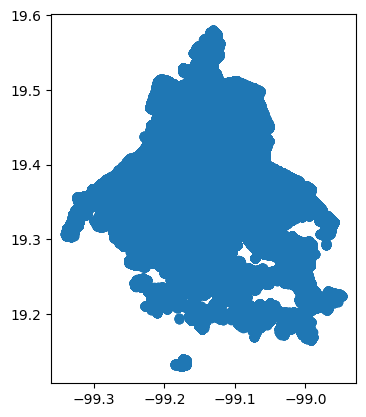

In [ ]:
datos_911 = gpd.GeoDataFrame(datos_911, 
                             geometry=gpd.points_from_xy(datos_911.longitud_centroide, 
                                                         datos_911.latitud_centroide))
datos_911 = datos_911.set_crs(epsg=4326)
datos_911.plot()

### Asociar a manzanas, colonias y cuadrantes

De acuerdo a la documentación la columna manzana contiene el identficador de la manzana del incidente en las bases de INEGI, sin embargo no queda claro a qué año se refiere la cartografía de manzanas, entonces mejor vamos a asociarlas a través de una unión espacial.

In [ ]:
unidos = (datos_911.sjoin(manzanas[['colonia_cve', 
                                  'cuadrante_id', 'geometry']].to_crs(datos_911.crs))
         .drop(columns='index_right'))
print( "Hay %s registros en la union espacial"%(unidos.shape[0]))

Hay 3572431 registros en la union espacial


:::{.callout-warning}

Estamos perdiendo bastantes registros, posiblemente algunos puntos no caigan dentro de las manzanas, eventualmente hay que intentar unir los restantes con `sjoin_nearest`

:::

In [ ]:
unidos.head()

,folio,incidente_c4,fecha_creacion,hora_creacion,mes_creacion,año_creacion,fecha_cierre,mes_cierre,año_cierre,hora_cierre,colonia,codigo_cierre,clas_con_f_alarma,delegacion_cierre,manzana,longitud_centroide,latitud_centroide,geometry,colonia_cve,cuadrante_id
0,C5/200702/07369,Lesionado-Caída,2020-07-02,21:25:59,Julio,2020.0,2020-07-02,Julio,2020.0,21:30:35,SALVADOR DIAZ MIRON,Duplicado,URGENCIAS MEDICAS,GUSTAVO A. MADERO,0900500012907021,-99.09506,19.48655,POINT (-99.09506 19.48655),635,015
6657,C5/200703/03163,Médicos-Convulsiones,2020-07-03,11:46:51,Julio,2020.0,2020-07-03,Julio,2020.0,11:52:46,SALVADOR DIAZ MIRON,Duplicado,URGENCIAS MEDICAS,GUSTAVO A. MADERO,0900500012907021,-99.09506,19.48655,POINT (-99.09506 19.48655),635,015
25901,C5/200712/00975,Disturbio-Fiestas,2020-07-12,01:39:46,Julio,2020.0,2020-07-12,Julio,2020.0,01:42:46,SALVADOR DIAZ MIRON,Duplicado,FALTA CÍVICA,GUSTAVO A. MADERO,0900500012907021,-99.09506,19.48655,POINT (-99.09506 19.48655),635,015
45484,C5/200709/04377,Disturbio-Escándalo,2020-07-09,16:44:01,Julio,2020.0,2020-07-09,Julio,2020.0,16:53:41,SALVADOR DIAZ MIRON,Negativo,FALTA CÍVICA,GUSTAVO A. MADERO,0900500012907021,-99.09506,19.48655,POINT (-99.09506 19.48655),635,015
48174,C5/200717/04329,Lesionado-Por Golpes-Agresión,2020-07-17,15:32:46,Julio,2020.0,2020-07-17,Julio,2020.0,15:49:46,SALVADOR DIAZ MIRON,Negativo,URGENCIAS MEDICAS,GUSTAVO A. MADERO,0900500012907021,-99.09506,19.48655,POINT (-99.09506 19.48655),635,015


Hasta aquí ya tenemos la base del 911 con identificadores de manzanas, colonias y cuadrantes. Sólo falta entonces procesar las fechas

In [ ]:
unidos['fecha_creacion'] = pd.to_datetime(unidos['fecha_creacion'], dayfirst=True)
unidos['fecha_creacion'].head()

0       2020-07-02
6657    2020-07-03
25901   2020-07-12
45484   2020-07-09
48174   2020-07-17
Name: fecha_creacion, dtype: datetime64[ns]

Esta base ya está lista para usarse en la librería, estará dsponible para descargarla pero no se instalará junto con la librería.

In [ ]:
datos_911.to_file(DOWNLOADS_PATH/"datos_911.gpkg", layer='incidentes',driver="GPKG")